<a href="https://colab.research.google.com/github/islomchickk/Machine-Learning-course/blob/main/detection_sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, RocCurveDisplay, accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')

import emoji

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Данные

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
Sarcasm = pd.read_json('/content/drive/MyDrive/Colab Notebooks/МО/ЕДЗ/Sarcasm.json', lines=True)
Sarcasm.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [10]:
sarcasm_df = Sarcasm[['headline', 'is_sarcastic']]
sarcasm_df.columns = ['text', 'sarcasm']
sarcasm_df.head()

,text,sarcasm
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     26709 non-null  object
 1   sarcasm  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


# Без преодобработки

## Подготовка данных

In [12]:
set(''.join(sarcasm_df['text'].tolist()))

{' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '\x97',
 '\x99',
 '\xa0',
 '¡',
 '©',
 '¯',
 '°',
 '¿',
 '×',
 'à',
 'á',
 'ã',
 'ä',
 'ç',
 'é',
 'ë',
 'í',
 'ï',
 'ñ',
 'ó',
 'ö',
 'ø',
 'û',
 'ü',
 'ſ',
 '̈',
 'λ',
 '\u200a',
 '\u200b',
 '–',
 '—',
 '―',
 '“',
 '”',
 '…',
 '™',
 'ツ'}

Видно, что в данных присутствуют много инородных символов. В следующем разделе попробуем избавиться от них.

Разделим датасет на Х и у для удобства.

In [13]:
X = sarcasm_df.text
y = sarcasm_df.sarcasm

Используем TF-IDF vectorizer для преобразования текста в числовой формат. Возьмем max_features=10000.

In [14]:
vectorizer = TfidfVectorizer(max_features=10000)

In [15]:
X_tfidf = vectorizer.fit_transform(X).toarray()

In [16]:
X_tfidf.shape

(26709, 10000)

Разделим датасет на тренировочную и тестовую выборки в соотношении 0,7:0,3 соответственно и random_state=42.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [18]:
X_tfidf.shape

(26709, 10000)

In [19]:
print(f'Разиер обучющей выборки: {X_train.shape}')
print(f'Разиер тестовой выборки: {X_test.shape}')

Разиер обучющей выборки: (18696, 10000)
Разиер тестовой выборки: (8013, 10000)


## LogisticRefression() - Baseline.

In [20]:
lr = LogisticRegression().fit(X_train, y_train)
y_lr = lr.predict(X_test)

В качестве метрики возьмем accuracy.

In [21]:
acc_lr = accuracy_score(y_test, y_lr)
acc_lr

0.844377885935355

## RandomForestClassifier

Деревья обычно плохосправляются с такими данными, но попытка не пытка)

In [22]:
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

y_rfc = rfc.predict(X_test)

acc_rfc = accuracy_score(y_test, y_rfc)
acc_rfc

0.8050667665044303

Я пробовал применить GridSearchCV для поиска оптимальной структуры деревьев, но у меня ноутбук завис, очень долго считал.

## SVM

In [23]:
# svm = SVC().fit(X_train, y_train)

# y_svm = svm.predict(X_test)

# acc_svm = accuracy_score(y_test, y_svm)
# acc_svm

Также очень долго считает, даже без GridSearchCV...

In [24]:
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_svm)
# roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
#                                    estimator_name='example estimator')
# display.plot()

# plt.show()

## XGBClassifier

На последок применим XGBClassifier

In [131]:
# xg = XGBClassifier().fit(X_train, y_train)
# y_xg = xg.predict(X_test)

# acc_xg = accuracy_score(y_test, y_xg)
# acc_xg

Ни один модель не смогла превысить baseline заданным LogisticRegression, поэтому посмотрим что скажут НС.

![](https://www.meme-arsenal.com/memes/f920fa75d0025495ffd6828bfbda0687.jpg)

## Нейронные сети

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

### Немного предобработки

In [27]:
sarcasm_df = Sarcasm[['headline', 'is_sarcastic']]
sarcasm_df.columns = ['text', 'sarcasm']
sarcasm_df.head()

,text,sarcasm
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [28]:
num_words = set()
max_news_len = []
for row in range(sarcasm_df.shape[0]):
    num_words = num_words | set((list(np.unique(sarcasm_df.text[row]))[0].split()))
    max_news_len.append(len(sarcasm_df.text[row]))

In [29]:
len(num_words)

36599

In [30]:
np.median(max_news_len)

61.0

In [31]:
num_words = 20000
max_news_len = 44
nb_classes = 2

In [32]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df.text, y, test_size=0.3, random_state=42)

In [33]:
y_train = utils.to_categorical(y_train, nb_classes)
y_test = utils.to_categorical(y_test, nb_classes)
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

#### Токенизация текста

Создаем токенизатор Keras и Обучаем его на заголовках новостей

In [34]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

Преобразуем новости в числовое представление

In [35]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

Ограничиваем длину заголовков

In [36]:
x_train = pad_sequences(sequences, maxlen=max_news_len)
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [37]:
x_train[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   251,    90,  1769,
          297,     1,  1575,   800,     2,  2111,    19, 12204]],
      dtype=int32)

### Сверточная нейронная сеть

In [38]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

In [39]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [40]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 32)            640000    
                                                                 
 conv1d (Conv1D)             (None, 40, 250)           40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 712,636
Trainable params: 712,636
Non-trainable params: 0
__________________________________________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [41]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [42]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
131/132 [============================>.] - ETA: 0s - loss: 0.4717 - accuracy: 0.7557
Epoch 1: val_accuracy improved from -inf to 0.86150, saving model to best_model_cnn.h5
132/132 [==============================] - 10s 61ms/step - loss: 0.4712 - accuracy: 0.7561 - val_loss: 0.3225 - val_accuracy: 0.8615
Epoch 2/5
131/132 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9253
Epoch 2: val_accuracy improved from 0.86150 to 0.87059, saving model to best_model_cnn.h5
132/132 [==============================] - 8s 60ms/step - loss: 0.1928 - accuracy: 0.9253 - val_loss: 0.3402 - val_accuracy: 0.8706
Epoch 3/5
131/132 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9804
Epoch 3: val_accuracy did not improve from 0.87059
132/132 [==============================] - 7s 53ms/step - loss: 0.0656 - accuracy: 0.9803 - val_loss: 0.4817 - val_accuracy: 0.8561
Epoch 4/5
131/132 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.

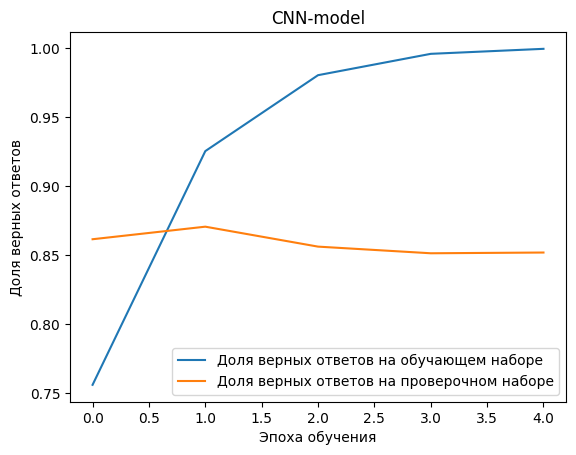

In [43]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.title('CNN-model')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [44]:
model_cnn.load_weights(model_cnn_save_path)
cnn = model_cnn.evaluate(x_test, y_test, verbose=1)[1]


251/251 [==============================] - 1s 5ms/step - loss: 0.3374 - accuracy: 0.8589


### Cеть LSTM

In [45]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(2, activation='softmax'))

In [46]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [47]:
model_lstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 44, 32)            640000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 643,170
Trainable params: 643,170
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [49]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
131/132 [============================>.] - ETA: 0s - loss: 0.5538 - accuracy: 0.6954
Epoch 1: val_accuracy improved from -inf to 0.85401, saving model to best_model_lstm.h5
132/132 [==============================] - 9s 39ms/step - loss: 0.5534 - accuracy: 0.6958 - val_loss: 0.3598 - val_accuracy: 0.8540
Epoch 2/5
132/132 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.9021
Epoch 2: val_accuracy improved from 0.85401 to 0.86791, saving model to best_model_lstm.h5
132/132 [==============================] - 4s 34ms/step - loss: 0.2578 - accuracy: 0.9021 - val_loss: 0.3180 - val_accuracy: 0.8679
Epoch 3/5
132/132 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9513
Epoch 3: val_accuracy did not improve from 0.86791
132/132 [==============================] - 6s 48ms/step - loss: 0.1410 - accuracy: 0.9513 - val_loss: 0.3618 - val_accuracy: 0.8615
Epoch 4/5
132/132 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0

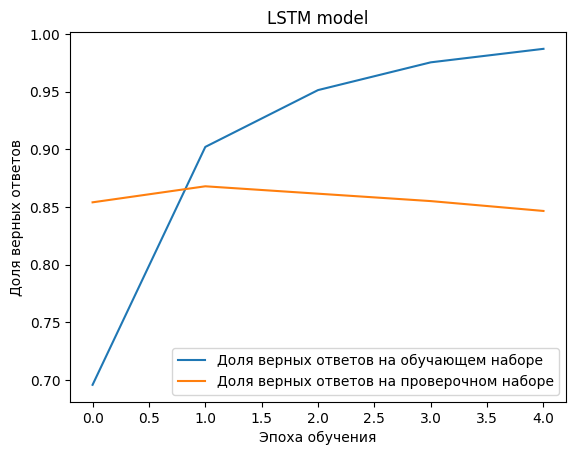

In [50]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.title('LSTM model')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [51]:
model_lstm.load_weights(model_lstm_save_path)
lstm = model_lstm.evaluate(x_test, y_test, verbose=1)[1]


251/251 [==============================] - 2s 8ms/step - loss: 0.3329 - accuracy: 0.8610


In [52]:
y_lstm = model_lstm.predict(x_test)

251/251 [==============================] - 2s 7ms/step


In [53]:
y_lstm

array([[0.0325371 , 0.9674629 ],
       [0.9739096 , 0.02609035],
       [0.72135526, 0.2786447 ],
       ...,
       [0.11434574, 0.8856543 ],
       [0.9442371 , 0.05576288],
       [0.9921366 , 0.00786341]], dtype=float32)

# С преобработкой

## Preprocessing

А теперь избавимся от лишних символов, слов и тд.

Для этого сначала загрузим punkt, wordnet, stopwords из библиотеки nltk.

In [54]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [55]:
def preprocess(text):
    try:
        text = list(filter(str.isalpha, word_tokenize(text.lower())))
        text = list(lemmatizer.lemmatize(word) for word in text)
        text = list(word for word in text if word not in stop_words)
        return ' '.join(text)
    except:
        return 'Error'

In [56]:
sarcasm_df['text_preproc'] = sarcasm_df.apply(lambda row: preprocess(row.text), axis=1)
sarcasm_df.head()

,text,sarcasm,text_preproc
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret code min...
1,the 'roseanne' revival catches up to our thorn...,0,revival catch thorny political mood better worse
2,mom starting to fear son's web series closest ...,1,mom starting fear son web series closest thing...
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative idea
4,j.k. rowling wishes snape happy birthday in th...,0,rowling wish snape happy birthday magical way


In [57]:
set(''.join(sarcasm_df['text_preproc'].tolist()))

{' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'à',
 'á',
 'ã',
 'ä',
 'ç',
 'é',
 'ë',
 'í',
 'ï',
 'ñ',
 'ó',
 'ö',
 'ø',
 'û',
 'ü',
 'ſ',
 'ツ'}

In [58]:
import re

dataset = sarcasm_df['text_preproc'].tolist()

# регулярное выражение для поиска слов, содержащих указанные символы
pattern = re.compile(r"\b\w*[àáâãäçèéëíîïðñóõöøúûüſツ]\w*\b")

# поиск слов в датасете, содержащих указанные символы
words_with_symbols = []
for text in dataset:
    words_with_symbols += pattern.findall(text)

print(words_with_symbols)

['café', 'café', 'bébé', 'décor', 'cüneyt', 'cliché', 'beyoncé', 'björk', 'éclairs', 'beyoncé', 'cáceres', 'résumé', 'misérables', 'café', 'timothée', 'nestlé', 'ツ', 'condé', 'café', 'appétit', 'déjeûner', 'são', 'rené', 'josé', 'andrés', 'résumé', 'beyoncé', 'beyoncé', 'bogotá', 'exposé', 'pasión', 'soirée', 'renée', 'renée', 'café', 'fiancé', 'motörhead', 'hispánico', 'chloë', 'beyoncé', 'virée', 'guantánamo', 'divorcée', 'bündchen', 'beyoncé', 'beyoncé', 'pelléas', 'mélisande', 'beyoncé', 'café', 'sørvágsvatn', 'jonbenét', 'garcía', 'márquez', 'denée', 'guantánamo', 'déjà', 'ünited', 'stätes', 'beyoncé', 'beyoncé', 'galápagos', 'sónar', 'maría', 'beyoncé', 'menéndez', 'galápagos', 'khloé', 'quinceañera', 'naïve', 'doppelgänger', 'détente', 'reggaetón', 'beyoncé', 'ragnarök', 'beyoncé', 'façade', 'fiancé', 'beyoncé', 'beyoncé', 'cafés', 'beyoncé', 'monáe', 'jalapeño', 'pokémon', 'résumé', 'déja', 'björk', 'condé', 'fiancé', 'voté', 'doppelgänger', 'résumé', 'américas', 'timothée', 'g

В принципе слов с символами обозначающие ударение или из специфических символов  не так много. Если результат предобработки окажется лучше, можно и их попробовать заменить.

Те же шаги что и в первой главе.

In [59]:
X = sarcasm_df.text_preproc
y = sarcasm_df.sarcasm

In [60]:
vectorizer = TfidfVectorizer(max_features=10000)

In [61]:
X_tfidf = vectorizer.fit_transform(X).toarray()

In [62]:
X_tfidf.shape

(26709, 10000)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [64]:
X_tfidf.shape

(26709, 10000)

In [65]:
print(f'Разиер обучющей выборки: {X_train.shape}')
print(f'Разиер тестовой выборки: {X_test.shape}')

Разиер обучющей выборки: (18696, 10000)
Разиер тестовой выборки: (8013, 10000)


In [66]:
lr_preproc = LogisticRegression().fit(X_train, y_train)
y_lr_preproc = lr_preproc.predict(X_test)

In [67]:
acc_lr_preproc = accuracy_score(y_test, y_lr_preproc)
acc_lr_preproc

0.7813552976413328

Точность стало на 0,1 ниже чем без преобработки, попробуем не удалять стоп слова, кавычки, !, ? и заменить буквы ударения (é) на обычные.

## Preprocessing 2.0

In [82]:
sarcasm_df = Sarcasm[['headline', 'is_sarcastic']]
sarcasm_df.columns = ['text', 'sarcasm']
sarcasm_df.head()

,text,sarcasm
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [83]:
dic = {
       'à': 'a', 
       'á': 'a', 
       'ã': 'a', 
       'ä': 'a', 
       'ë': 'e', 
       'é': 'e', 
       'í': 'i', 
       'ï': 'i', 
       '¡': 'i', 
       'ñ': 'n', 
       'ó': 'o', 
       'ö': 'o', 
       'û': 'u', 
       'ü': 'u', 
       '*': '', 
       '\x97': '', 
       '\x99': '', 
       '\xa0': '', 
       '[': '', 
       '\u200a': '', 
       '\u200b': '', 
       '–': '', 
       '°': '', 
       '™': '', 
       'λ': '', 
       'ſ': '', 
       'ø': '', 
       'ç': '', 
       '×': '', 
       '#': '', 
       '$': '', 
       '%': '', 
       '&': '', 
       '+': '', 
       '/': '', 
       ';': '', 
       '<': '', 
       '=': '', 
       '>': '', 
       '@': '', 
       '\\': '', 
       ']': '', 
       '^': '', 
       '{': '', 
       '|': '',
       '}': '', 
       '~': '', 
       '1': '', 
       '2': '', 
       '3': '', 
       '4': '', 
       '5': '', 
       '6': '', 
       '7': '', 
       '8': '', 
       '9': '', 
       '0': '' 
      }


{'à': 'a', 'á': 'a', 'ã': 'a', 'ä': 'a', 'ë': 'e', 'é': 'e', 'í': 'i', 'ï': 'i', '¡': 'i', 'ñ': 'n', 'ó': 'o', 'ö': 'o', 'û': 'u', 'ü': 'u', '*': '', '\x97': '', '\x99': '', '\xa0': '', '[': '', '\u200a': '', '\u200b': '', '–': '', '°': '', '™': '', 'λ': '', 'ſ': '', 'ø': '', 'ç': '', '×': '', '#': '', '$': '', '%': '', '&': '', '+': '', '/': '', ';': '', '<': '', '=': '', '>': '', '@': '', '\\': '', ']': '', '^': '', '{': '', '|': '', '}': '', '~': '', '1': '', '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': '', '0': ''}


In [84]:
def clean_text(text):
    table = str.maketrans(dic)
    text = text.translate(table)
    return text

In [85]:
sarcasm_df.text = sarcasm_df.text.apply(clean_text)

In [87]:
X = sarcasm_df.text
y = sarcasm_df.sarcasm

In [88]:
vectorizer = TfidfVectorizer(max_features=10000)

In [89]:
X_tfidf = vectorizer.fit_transform(X).toarray()

In [90]:
X_tfidf.shape

(26709, 10000)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [92]:
X_tfidf.shape

(26709, 10000)

In [93]:
print(f'Разиер обучющей выборки: {X_train.shape}')
print(f'Разиер тестовой выборки: {X_test.shape}')

Разиер обучющей выборки: (18696, 10000)
Разиер тестовой выборки: (8013, 10000)


## LogisticRegression

In [94]:
lr_preproc = LogisticRegression().fit(X_train, y_train)
y_lr_preproc = lr_preproc.predict(X_test)

In [95]:
acc_lr_preproc = accuracy_score(y_test, y_lr_preproc)
acc_lr_preproc

0.8452514663671534

## RandomForestClassifier

In [96]:
rfc_preproc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

y_rfc_preproc = rfc_preproc.predict(X_test)

acc_rfc_preproc = accuracy_score(y_test, y_rfc)
acc_rfc_preproc

0.8050667665044303

In [97]:
# svm_preproc = SVC().fit(X_train, y_train)

# y_svm_preproc = svm_preproc.predict(X_test)

# acc_svm_preproc = accuracy_score(y_test, y_svm_preproc)
# acc_svm_preproc

In [98]:
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_svm_preproc)
# roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
#                                    estimator_name='example estimator')
# display.plot()

# plt.show()

In [99]:
# xg_preproc = XGBClassifier().fit(X_train, y_train)
# y_xg_preproc = xg_preproc.predict(X_test)

# acc_xg_preproc = accuracy_score(y_test, y_xg_preproc)
# acc_xg_preproc

## Нейронные сети

### Немного предобработки

In [132]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df.text, y, test_size=0.3, random_state=42)


In [133]:
y_train = utils.to_categorical(y_train, nb_classes)
y_test = utils.to_categorical(y_test, nb_classes)
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Токенизация текста

Создаем токенизатор Keras и Обучаем его на заголовках новостей

In [104]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

Преобразуем новости в числовое представление

In [105]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

Ограничиваем длину заголовков

In [106]:
x_train = pad_sequences(sequences, maxlen=max_news_len)
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [107]:
x_train[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  240,   89, 1738,  284,    1, 1543,  779,    2, 2077,   19]],
      dtype=int32)

### Сверточная нейронная сеть

In [108]:
model_cnn_preproc = Sequential()
model_cnn_preproc.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn_preproc.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn_preproc.add(GlobalMaxPooling1D())
model_cnn_preproc.add(Dense(128, activation='relu'))
model_cnn_preproc.add(Dense(2, activation='softmax'))

In [109]:
model_cnn_preproc.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [110]:
model_cnn_preproc.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 44, 32)            640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 250)           40250     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 128)               32128     
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 712,636
Trainable params: 712,636
Non-trainable params: 0
________________________________________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [111]:
model_cnn_preproc_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_preproc_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [112]:
history_cnn_preproc = model_cnn_preproc.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
131/132 [============================>.] - ETA: 0s - loss: 0.4887 - accuracy: 0.7338
Epoch 1: val_accuracy improved from -inf to 0.84225, saving model to best_model_cnn.h5
132/132 [==============================] - 8s 52ms/step - loss: 0.4881 - accuracy: 0.7340 - val_loss: 0.3579 - val_accuracy: 0.8422
Epoch 2/5
131/132 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9202
Epoch 2: val_accuracy improved from 0.84225 to 0.86096, saving model to best_model_cnn.h5
132/132 [==============================] - 9s 70ms/step - loss: 0.2032 - accuracy: 0.9201 - val_loss: 0.3524 - val_accuracy: 0.8610
Epoch 3/5
131/132 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9786
Epoch 3: val_accuracy did not improve from 0.86096
132/132 [==============================] - 6s 48ms/step - loss: 0.0692 - accuracy: 0.9786 - val_loss: 0.4626 - val_accuracy: 0.8599
Epoch 4/5
131/132 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9

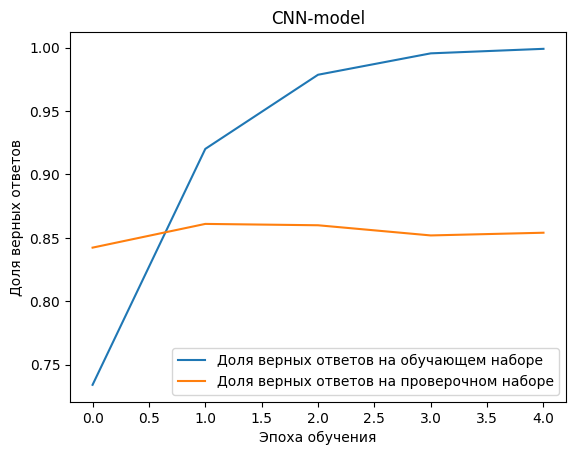

In [113]:
plt.plot(history_cnn_preproc.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn_preproc.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.title('CNN-model')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [114]:
model_cnn_preproc.load_weights(model_cnn_preproc_save_path)
cnn_preproc = model_cnn_preproc.evaluate(x_test, y_test, verbose=1)[1]
cnn_preproc

251/251 [==============================] - 1s 5ms/step - loss: 0.3679 - accuracy: 0.8484


0.8483713865280151

### Cеть LSTM

In [115]:
model_lstm_preproc = Sequential()
model_lstm_preproc.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm_preproc.add(LSTM(16))
model_lstm_preproc.add(Dense(2, activation='softmax'))

In [116]:
model_lstm_preproc.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [117]:
model_lstm_preproc.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 44, 32)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 643,170
Trainable params: 643,170
Non-trainable params: 0
_________________________________________________________________


In [118]:
model_lstm_preproc_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_preproc_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [119]:
history_lstm_preproc = model_lstm_preproc.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.6810
Epoch 1: val_accuracy improved from -inf to 0.84278, saving model to best_model_lstm.h5
132/132 [==============================] - 8s 45ms/step - loss: 0.5685 - accuracy: 0.6810 - val_loss: 0.3856 - val_accuracy: 0.8428
Epoch 2/5
131/132 [============================>.] - ETA: 0s - loss: 0.2732 - accuracy: 0.8931
Epoch 2: val_accuracy improved from 0.84278 to 0.87059, saving model to best_model_lstm.h5
132/132 [==============================] - 6s 47ms/step - loss: 0.2733 - accuracy: 0.8929 - val_loss: 0.3219 - val_accuracy: 0.8706
Epoch 3/5
131/132 [============================>.] - ETA: 0s - loss: 0.1498 - accuracy: 0.9488
Epoch 3: val_accuracy did not improve from 0.87059
132/132 [==============================] - 5s 39ms/step - loss: 0.1497 - accuracy: 0.9488 - val_loss: 0.3552 - val_accuracy: 0.8610
Epoch 4/5
132/132 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0

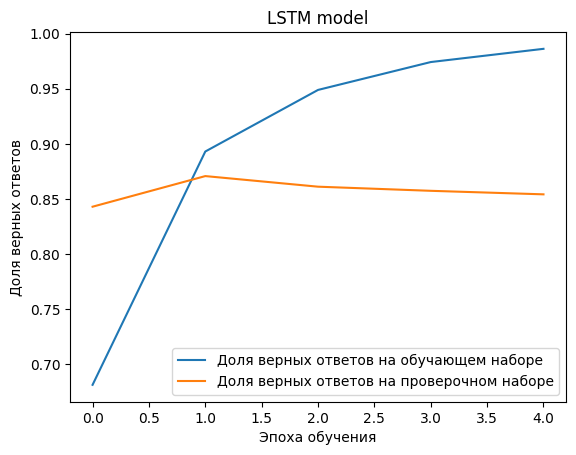

In [120]:
plt.plot(history_lstm_preproc.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm_preproc.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.title('LSTM model')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [121]:
model_lstm_preproc.load_weights(model_lstm_preproc_save_path)
lstm_preproc = model_lstm_preproc.evaluate(x_test, y_test, verbose=1)[1]
lstm_preproc

251/251 [==============================] - 2s 7ms/step - loss: 0.3316 - accuracy: 0.8570


0.856982409954071

In [122]:
y_lstm_preproc = model_lstm_preproc.predict(x_test)

251/251 [==============================] - 2s 6ms/step


# Результаты.

In [127]:
lstm_

[0.8609759211540222, 0.856982409954071]

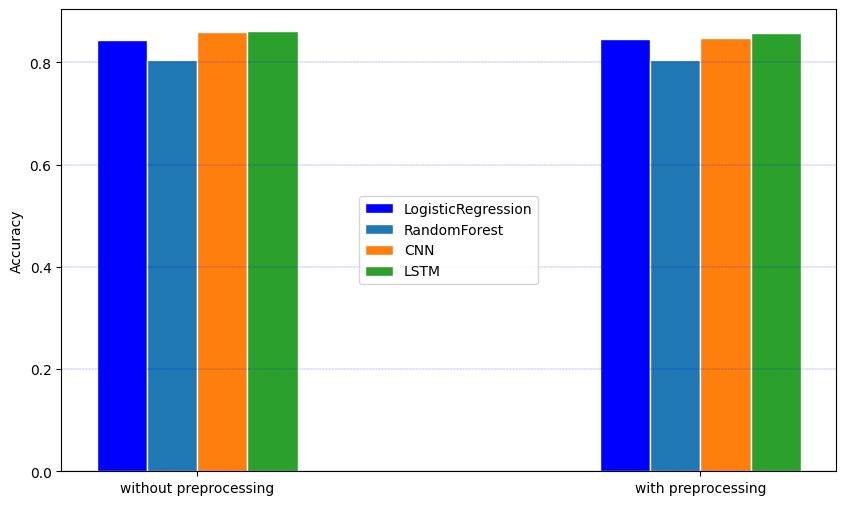

In [130]:
plt.figure(figsize=(10, 6))


# set width of bars
barWidth = 0.1

# set heights of bars
log_reg = [acc_lr, acc_lr_preproc]
random_forest = [acc_rfc, acc_rfc_preproc]
# svm_ = [acc_svm, acc_svm_preproc]
# xgb = [acc_xg, acc_xg_preproc]
cnn_ = [cnn, cnn_preproc]
lstm_ = [lstm, lstm_preproc]

 
# Set position of bar on X axis
r1 = np.arange(len(log_reg))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
# r5 = [x + barWidth for x in r4]
# r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, log_reg, color='blue', width=barWidth, edgecolor='white', label='LogisticRegression')
plt.bar(r2, random_forest, width=barWidth, edgecolor='white', label='RandomForest')
# plt.bar(r3, svm_, width=barWidth, edgecolor='white', label='SVM')
# plt.bar(r4, xgb, width=barWidth, edgecolor='white', label='XGBoost')
plt.bar(r3, cnn_, width=barWidth, edgecolor='white', label='CNN')
plt.bar(r4, lstm_, width=barWidth, edgecolor='white', label='LSTM')
 
# Add xticks on the middle of the group bars
# plt.xlabel('group', fontweight='bold')
plt.xticks([r + 1.5*barWidth for r in range(len(log_reg))], ['without preprocessing', 'with preprocessing'])


plt.grid(axis = 'y',
        color = 'blue',
        linewidth = 0.2,
        linestyle = '--'
)
# Create legend & Show graphic
plt.legend(loc='center')
plt.ylabel('Accuracy')
plt.show()